## 필요 패키지 로드

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
import pandas as pd


from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터셋 불러오기
- 32 X 32 크기의 컬러 데이터셋

In [7]:
cifar10 = tf.keras.datasets.cifar10

(train_x, label_x), (test_x, label_y) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### 훈련의 속도를 위해 라벨별로 학습을 해보자
- 0: airplane 1: automobile, 2: brid, 3:cat, 4: deer, 5:dog, 6: frog, 7: horse, 8: ship, 9: truck

In [9]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [32]:
truck_train_x, truck_test_x = load_data(9)

### 정규화 시키기
- 0~255 범위의 픽셀 데이터를 -1  ~  1 범위로 정규화를 진행해준다.

In [33]:
truck_train_x = (truck_train_x - 127.5) / 127.5

In [34]:
truck_train_x = truck_train_x.reshape(truck_train_x.shape[0], 32, 32, 3).astype('float32')

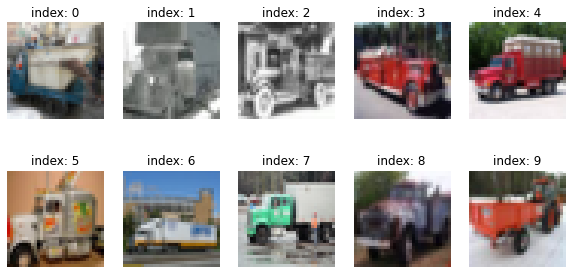

In [40]:
plt.figure(figsize=(10, 5)) # 전체 프레임의 크기

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러개 띄우고 싶을때 (row, col, index)
    random_index = np.random.randint(1, 5000)
    plt.imshow((truck_train_x[random_index]+1)/2.0)
    plt.title(f'index: {i}')
    plt.axis('off') # 불필요한 축 제거
plt.show()

### Dataset 만들어주기
- CIFAR 데이터셋은 10개의 클래스가 있고, 각 클래스마다 5000 개씩 데이터가 있다.

In [37]:
BUFFER_SIZE = 5000 # 전체 데이터를 섞기위해 같은 크기로
BATCH_SIZE = 128 # 모델이 한번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(truck_train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 생성자 모델
- 32,32,3 이미지를 생성하는 모델을 구현해보자

In [57]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [58]:
generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)        

### 난수 생성으로 이미지가 제대로 만들어지는지 확인하기

In [59]:
noise = tf.random.normal([1, 100])

# 훈련중이 아니니 training=False를 해주어야한다.
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

TensroShape(batchsize, w, h, c)

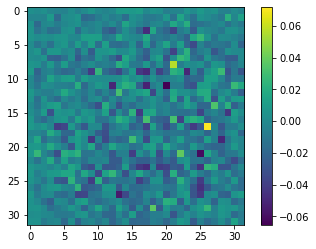

In [61]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### 판별자 생성하기
- 32,32,3 이미지를 입력받아 1dim 으로 판별 결과를 출력하는 모델 구현

In [46]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [47]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [60]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00105034]], dtype=float32)>

## 손실함수와 최적화 함수

### 손실함수

fake인가 real인가 판별하면 되브로 binary를 사용한다.

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- 생성자 loss

In [63]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- 판별자 loss

In [64]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- 판별자 accuracy

In [65]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화함수

In [66]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [67]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Train에 필요한 함수들 선언

- train step

In [68]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- 이미지 저장

In [90]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8')) # -1 ~ 1 을 0 ~ 255 로 돌려야한다
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- loss값 그리는 함수

In [77]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- checkpoint 만드는 함수

In [78]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- train 함수

In [79]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 학습하기

In [80]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

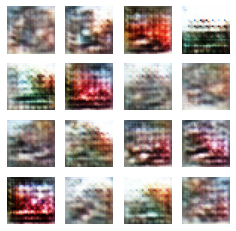

Time for training : 142 sec


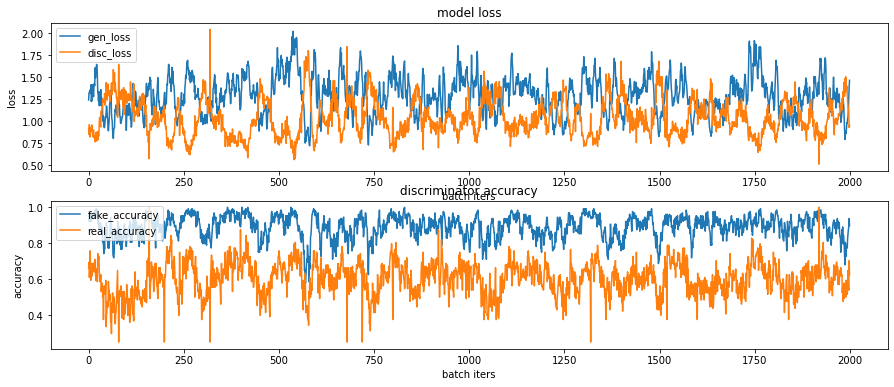

CPU times: user 1min 59s, sys: 27.2 s, total: 2min 26s
Wall time: 2min 22s


In [91]:
%%time
train(train_dataset, EPOCHS, save_every)

### 학습과정 시각화하기 (gif생성)

In [94]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_truck1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1094215 Feb 15 09:32 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![no_img](./dcgan_newimage/cifar10/cifar_truck1.gif)

### 뭔가 만들어지기는 하지만 아직 육안으로는 구별하기 힘들다.
- epoch을 좀더 늘려보자

In [95]:
save_every = 10
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

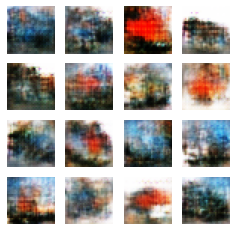

Time for training : 900 sec


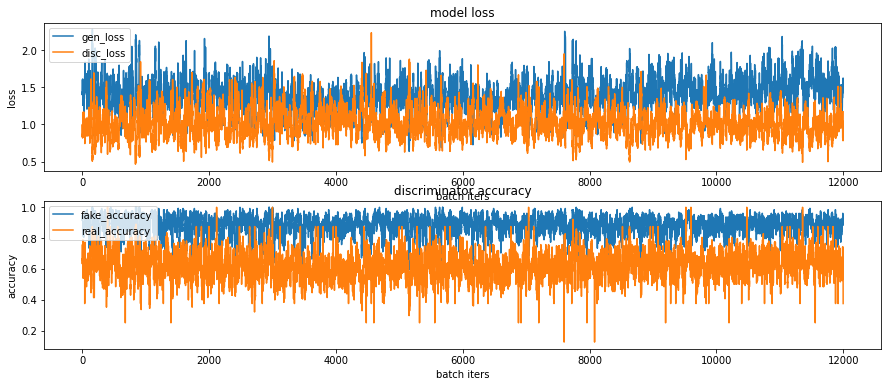

CPU times: user 12min 34s, sys: 2min 40s, total: 15min 15s
Wall time: 15min 1s


In [96]:
%%time
train(train_dataset, EPOCHS, save_every)

In [97]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_truck_epoch_300.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1094215 Feb 15 09:32 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![no_img](./dcgan_newimage/cifar10/cifar_truck_epoch_300.gif)

### 형태가 보이는듯 하지만 아직은 무리인듯하다.
- 튜닝해볼 파라미터를 찾아보자
 - 배치 사이즈 바꾸기
 - 모델 레이어 변경 및 레이어 파라미터 변경
 - leakyRelu 파라미터 바꿔보기 (default = 0.3)
 - 최적화 함수 학습률 바꿔보기

In [130]:
def make_generator_model_modify():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # six: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [131]:
generator_modify = make_generator_model_modify()

generator_modify.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_15 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 4, 4, 256)        

In [103]:
noise = tf.random.normal([1, 100])

# 훈련중이 아니니 training=False를 해주어야한다.
generated_image1 = generator_modify(noise, training=False)
generated_image1.shape

TensorShape([1, 32, 32, 3])

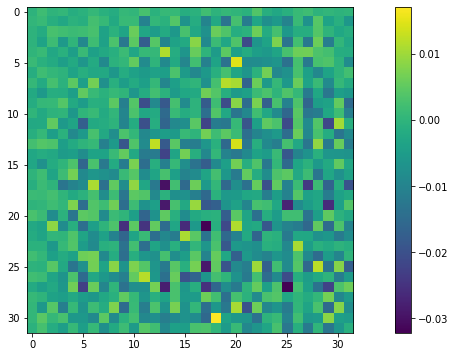

In [104]:
plt.imshow(generated_image1[0, :, :, 0])
plt.colorbar()
plt.show()

In [132]:
@tf.function
def train_step_modify(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_modify(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_modify.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_modify.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [133]:
def train_modify(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_modify(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_modify, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_modify, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [117]:
save_every = 10
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

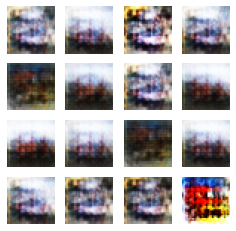

Time for training : 1043 sec


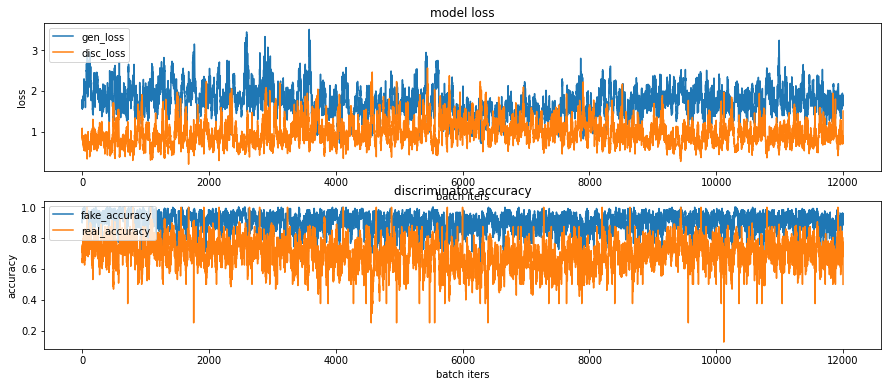

CPU times: user 13min 3s, sys: 2min 45s, total: 15min 49s
Wall time: 17min 24s


In [118]:
%%time
train_modify(train_dataset, EPOCHS, save_every)

In [119]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_truck_epoch_300_modify.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1094215 Feb 15 09:32 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![no_img](./dcgan_newimage/cifar10/cifar_truck_epoch_300_modify.gif)

### 트럭 말고 데이터셋 전체를 해보자 (트럭 데이터로는 부족한가? 전체 데이터로 해보자)

In [122]:
train_x = (train_x - 127.5) / 127.5
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

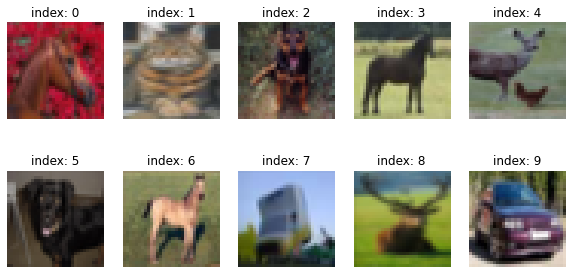

In [124]:
plt.figure(figsize=(10, 5)) # 전체 프레임의 크기

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러개 띄우고 싶을때 (row, col, index)
    random_index = np.random.randint(1, 5000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {i}')
    plt.axis('off') # 불필요한 축 제거
plt.show()

In [127]:
BUFFER_SIZE = 50000 # 전체 데이터를 섞기위해 같은 크기로
BATCH_SIZE = 512 # 모델이 한번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [135]:
save_every = 10
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

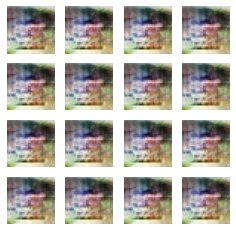

Time for training : 5767 sec


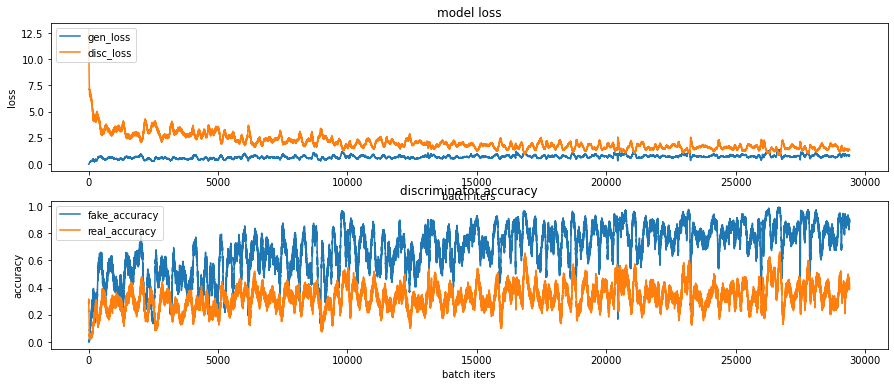

CPU times: user 1h 43min 23s, sys: 7min 13s, total: 1h 50min 36s
Wall time: 1h 36min 8s


In [137]:
%%time
train_modify(train_dataset, EPOCHS, save_every)

In [3]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_epoch_300_modify.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1094215 Feb 15 09:32 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![no_img](./dcgan_newimage/cifar10/cifar_epoch_300_modify.gif)

### 루브릭 관련
1. GAN 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
 - 트럭만 가지고 이미지를 생성할때는 조금씩 다르게 생성이 되었지만, cifar10 데이터를 전부를 로드에서 학습을한때는 전부 같은 이미지로만 바뀌는 점이 아쉬웠다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
 - 생성 이미지는 품질이 서서히 향상 되었지만, fake_accuracy가 점점 증가하는것으로봐서 잘못 학습이 진행된듯하다.
3. 추가적인 gan 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용했다.
 - 아쉽게 이부분은 못했다.

## 회고
이번 익스는 GAN 모델을 활용한 이미지 생성이였다.  
이번 익스의 주요 흐름은 데이터셋을 구성하고 -> 생성자 모델, 판별자 모델 -> 손실함수 최적화함수 -> 훈련과정 상세 구현하기 -> 학습 이였다.  
이전에는 레이어를 쌓고나서 바로 모델을 학습을 했던 것에 비해서, 이번엔 tensorflow의 훈련 과정을 직접 컨트롤 해보는 시도였다.  
GAN 모델의 특성상 두가지의 네트워크를 경쟁시키면서 학습을 하는 모델이다보니, 이전에 해오던 과정으론 한계가 있어서 GradientTape을 이용해서 모델을 구성했다.  
앞으로 과정을 생각해보면 기존에 제공하는 모델과 평가를 이용하는것이 아닌 이번 익스와 같이 직접 튜닝해서 사용하는 방법에 익숙해져야 할듯하다.  

처음에는 별 모양이 없는 노이즈에서 학습을 거듭할수록 이미지가 첨차 생긴다는 점에서 흥미가 생겼다.  
하지만 이미지를 판별할만한 하다가도 이게 무엇인지 정확히 판별을 하지 못한 아쉬움은 있었다.
모델을 한번 테스트 하는데 시간이 오래 걸리다보니, 생각했던 부분을 다양하게 테스트하지 못해서 아쉬웠다.  
GAN 모델을 소개하는 부분이 책한권 분량이 나올정도로 방대한 양이지만, 이번에는 겉할기로 진행한듯해서 다음 going deeper에 다시 GAN 모델을 좀더 이해하고, 다양한 튜닝을 통해서 좀더 깊은 이해를 했으면 좋겠다.